In [2]:
import numpy as np
print(np.__version__) # must be less than "2"
import matplotlib.pyplot as plt
%matplotlib inline

1.26.4


In [3]:
import torch
import torch.nn as nn

In [4]:
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler

In [5]:
import torchvision
from torchvision import transforms, datasets

In [6]:
data_dir= "catdogdata/kagglecatsanddogs_3367a/PetImages"

In [7]:
image_size = 64

data_transforms = transforms.Compose([transforms.Resize(image_size),
                                      transforms.CenterCrop(image_size),
                                      transforms.Grayscale(num_output_channels=1),
                                      transforms.ToTensor()
                                     ])

dataset = datasets.ImageFolder(data_dir,transform = data_transforms)

classes = dataset.classes
print(classes)
img, label = dataset[0]
print(img.shape,label)

['Cat', 'Dog']
torch.Size([1, 64, 64]) 0


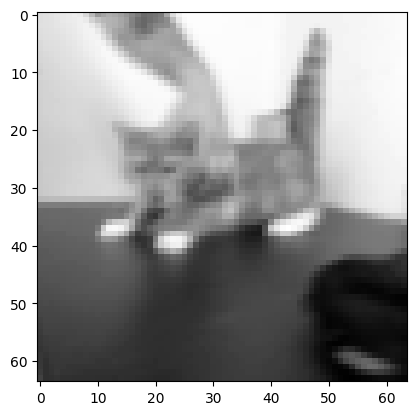

In [8]:
img = img.reshape(64,64,-1)
plt.imshow(img,cmap="gray")

In [9]:
batch_size = 128
valid_size = 0.20
test_size = 0.10

dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

split1 = int(np.floor(valid_size * dataset_size))
split2 = int(np.floor(test_size*dataset_size)) + split1
print(split1,split2)

valid_idx, test_idx, train_idx = indices[:split1], indices[split1:split2],indices[split2:]

training_data_sampler = SubsetRandomSampler(train_idx)
valid_data_sampler = SubsetRandomSampler(valid_idx)
test_data_sampler = SubsetRandomSampler(test_idx)

train_loader = DataLoader(dataset, sampler = training_data_sampler, batch_size = batch_size)
val_loader    = DataLoader(dataset, sampler = valid_data_sampler, batch_size = batch_size)
test_loader     = DataLoader(dataset, sampler = test_data_sampler, batch_size = batch_size)

4991 7486


In [10]:
class Model(nn.Module):
    def __init__(self):

        super(Model, self).__init__()
        self.network = nn.Sequential(

            # - x 1 x 64 x 64
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            # - x 32 x 32 x 32
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            # - x 64 x 16 x 16
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            # - x 128 x 8 x 8
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            # - x 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4,512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.network(x)
        return x


In [11]:
device = 'cpu'  # torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
print(device)

cpu


In [18]:
model = Model()

In [19]:
criterion = nn.BCELoss()
optimiser = optim.SGD(model.parameters(), lr= 0.001)

In [14]:
def train(epochs):
  for epoch in range(epochs):
    model.train()
    for batch in train_loader:
      xb, labels = batch
      labels = labels.view(-1,1).float()
      ypred = model(xb).float()
      loss = criterion(ypred,labels)
      loss.backward()
      optimiser.step()
      optimiser.zero_grad
    model.eval()
    val_loss = 0.0
    correct_preds = 0
    val_size = 0
    for batch in val_loader:
      xb, labels = batch
      labels = labels.view(-1,1).float()
      ypred = model(xb).float()
      loss = criterion(ypred,labels)
      val_loss += loss.data.item()*labels.shape[0]
      val_size += labels.shape[0]
      binary_preds = (ypred >= 0.5).int()
      correct_preds += (binary_preds == labels).sum().item()
    val_loss = val_loss/val_size
    val_accuracy = correct_preds/val_size
    print(f"Epoch: {epoch+1} val_loss= {val_loss:.4f} val_accuracy= {val_accuracy:.4f}")

In [15]:
def test():
    model.eval()
    correct_preds = 0
    test_size = 0
    for batch in test_loader:
      xb, labels = batch
      labels = labels.view(-1,1).float()
      ypred = model(xb).float()
      test_size += labels.shape[0]
      binary_preds = (ypred >= 0.5).int()
      correct_preds += (binary_preds == labels).sum().item()
    test_accuracy = correct_preds/test_size
    print(f"Accuracy on test data: {test_accuracy:.4f}")

In [16]:
test()

Accuracy on test data: 0.5030


In [20]:
num_epochs = 25
train(num_epochs)

Epoch: 1 val_loss= 0.6940 val_accuracy= 0.4887
Epoch: 2 val_loss= 0.6917 val_accuracy= 0.5207
Epoch: 3 val_loss= 0.6911 val_accuracy= 0.5093
Epoch: 4 val_loss= 0.6856 val_accuracy= 0.5358
Epoch: 5 val_loss= 0.6756 val_accuracy= 0.5804
Epoch: 6 val_loss= 0.6666 val_accuracy= 0.5822
Epoch: 7 val_loss= 0.6441 val_accuracy= 0.6353
Epoch: 8 val_loss= 0.6215 val_accuracy= 0.6674
Epoch: 9 val_loss= 0.5962 val_accuracy= 0.6908
Epoch: 10 val_loss= 0.5974 val_accuracy= 0.6906
Epoch: 11 val_loss= 0.5904 val_accuracy= 0.6868
Epoch: 12 val_loss= 0.5623 val_accuracy= 0.7157
Epoch: 13 val_loss= 0.5543 val_accuracy= 0.7207
Epoch: 14 val_loss= 0.5347 val_accuracy= 0.7269
Epoch: 15 val_loss= 0.5639 val_accuracy= 0.7017
Epoch: 16 val_loss= 0.5590 val_accuracy= 0.7257
Epoch: 17 val_loss= 0.5184 val_accuracy= 0.7407
Epoch: 18 val_loss= 0.5204 val_accuracy= 0.7512
Epoch: 19 val_loss= 0.5033 val_accuracy= 0.7572
Epoch: 20 val_loss= 0.4979 val_accuracy= 0.7714
Epoch: 21 val_loss= 0.5282 val_accuracy= 0.7784
E

In [21]:
test()

Accuracy on test data: 0.7639
